# PREVENDO SOBREVIVENTES DO TITANIC

Utilizando os datasets de treino e teste disponibilizados no desafio "Machine Learning from Disaster" da plataforma Kaggle, serão aplicados os algoritmos de Random Forest, Decision Tree, Logistic Regression e KNN para prever os sobreviventes do Titanic.

# 1.0 Importando as bibliotecas

In [1]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns

from sklearn.ensemble        import RandomForestClassifier
from sklearn.tree            import DecisionTreeClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

sns.set()

# 2.0 Importando datasets

In [2]:
train = pd.read_csv('Base de Dados/train.csv')

test = pd.read_csv('Base de Dados/test.csv')

In [3]:
train.shape, test.shape

((891, 12), (418, 11))

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# 3.0 Data Wrangling

In [6]:
train = train.drop(columns=['PassengerId','Name','Ticket'], axis=1)
test = test.drop(columns=['PassengerId','Name','Ticket'], axis=1)

## 3.1 Missing Values

In [7]:
train.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [8]:
test.isna().sum()

Pclass        0
Sex           0
Age          86
SibSp         0
Parch         0
Fare          1
Cabin       327
Embarked      0
dtype: int64

### 3.1.1 Age

Text(0.5, 1.0, 'Distribuição das idades - Teste')

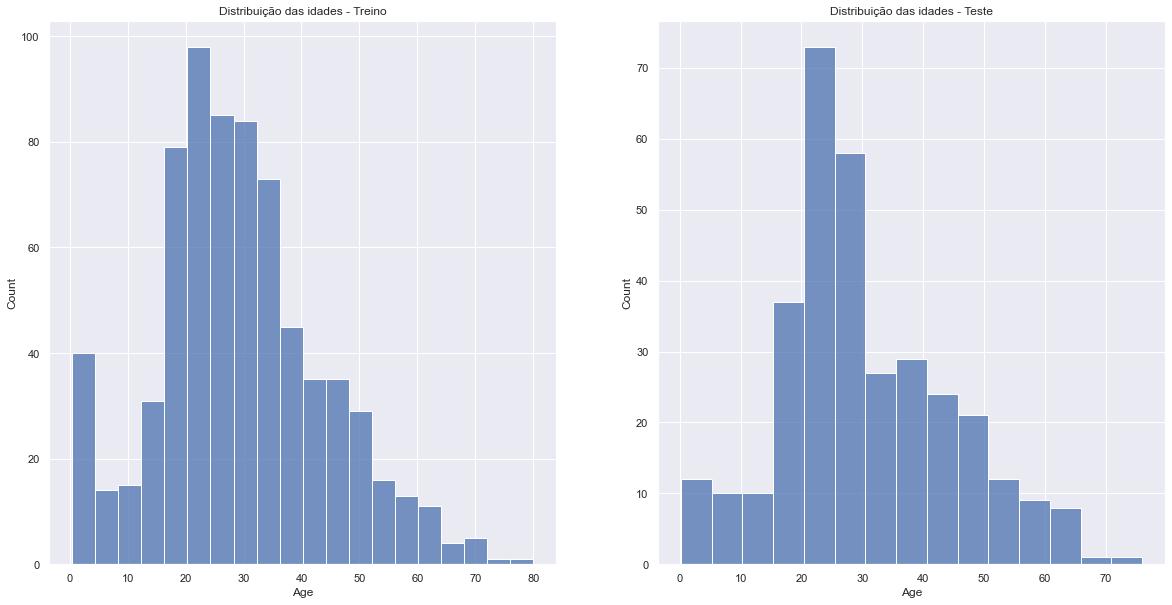

In [9]:
plt.figure(figsize=(20,10))

plt.subplot(1,2,1)
sns.histplot(train['Age'])
plt.title('Distribuição das idades - Treino')
plt.subplot(1,2,2)
sns.histplot(test['Age'])
plt.title('Distribuição das idades - Teste')

Diante da distribuição dos datasets, aparentando não ser uma distribuição normal, decidiu-se por preencher os missing values da variável 'Age' com o valor da sua mediana.

In [10]:
idade_mediana = train['Age'].median()

train['Age'] = train['Age'].fillna(idade_mediana)

In [11]:
idade_mediana = test['Age'].median()

test['Age'] = test['Age'].fillna(idade_mediana)

In [12]:
train.isna().sum() + test.isna().sum()

Age            0.0
Cabin       1014.0
Embarked       2.0
Fare           1.0
Parch          0.0
Pclass         0.0
Sex            0.0
SibSp          0.0
Survived       NaN
dtype: float64

### 3.1.2 Cabin

Por possuir muitos dados faltantes, optou-se por descartar a variável.

In [13]:
train = train.drop(columns=['Cabin'], axis=1)
test = test.drop(columns=['Cabin'], axis=1)

### 3.1.2 Embarked

In [14]:
train['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

Substituir o dado faltante pelo seu valor mais comum.

In [15]:
common_value = 'S'
data = [train, test]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

### 3.1.2 Fare

Text(0.5, 1.0, 'Distribuição das tarifas - Teste')

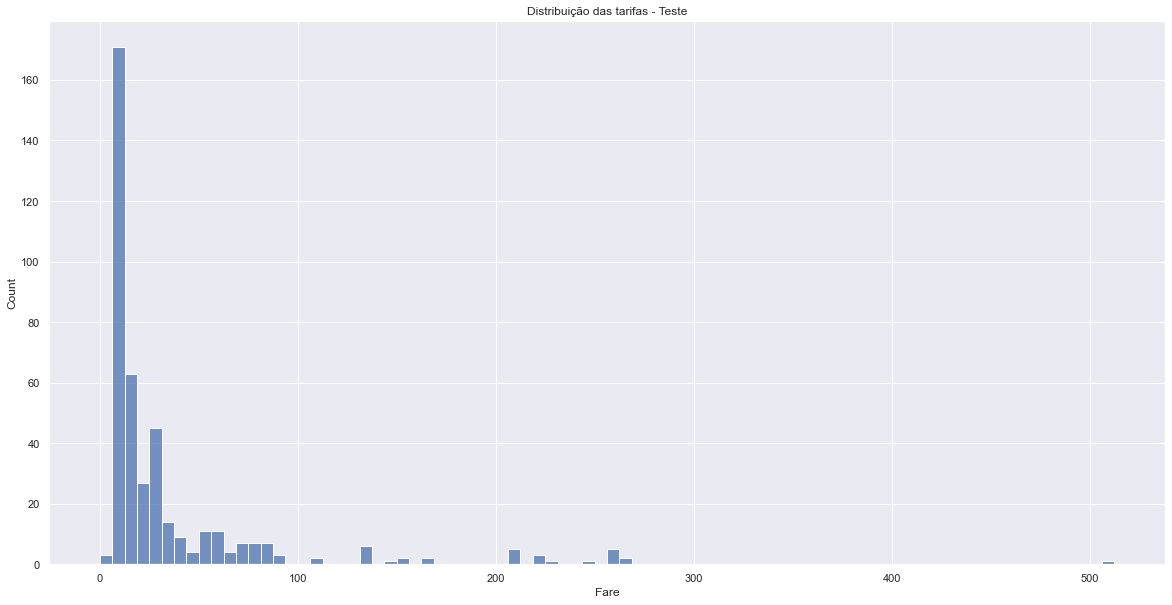

In [16]:
plt.figure(figsize=(20,10))

sns.histplot(test['Fare'])
plt.title('Distribuição das tarifas - Teste')

Por apresentar distribuição não normal, decidiu-se por preencher os valores faltantes da variável pela sua mediana.

In [17]:
test['Fare'] = test['Fare'].fillna(test['Fare'].median())
test['Fare'] = test['Fare'].astype(float)

In [18]:
train.isna().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [19]:
test.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

## 3.2 Data Types

In [20]:
train.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

In [21]:
test.dtypes

Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

In [22]:
train['Age'] = train['Age'].astype(int)

test['Age'] = test['Age'].astype(int)

# 4.0 Data Preparation

Substituir os dados categórios em numéricos, para que sejam aplicados os algoritmos de Machine Learning.

## 4.1 Sex

In [23]:
genders = {"male": 0, "female": 1}
data = [train, test]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

## 4.2 Embarked

In [24]:
ports = {"S": 0, "C": 1, "Q": 2}
data = [train, test]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

## 4.3 Age

In [25]:
data = [train, test]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 7

In [26]:
train['Age'].value_counts()

4    303
6    141
3    106
5    103
2     92
1     71
0     68
7      7
Name: Age, dtype: int64

## 4.4 Fare

In [27]:
data = [train, test]

for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

# 5.0 Machine Learning

In [28]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,2,1,0,0,0
1,1,1,1,5,1,0,3,1
2,1,3,1,3,0,0,1,0
3,1,1,1,5,1,0,3,0
4,0,3,0,5,0,0,1,0


In [29]:
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,5,0,0,0,2
1,3,1,6,1,0,0,0
2,2,0,6,0,0,1,2
3,3,0,3,0,0,1,0
4,3,1,2,1,1,1,0


Preparando os arquivos

In [30]:
X_train = train.drop("Survived", axis=1)
Y_train = train["Survived"]

x_test  = test.copy()

## 5.1 Random Forest

In [31]:
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(x_test)

random_forest.score(X_train, Y_train)

result_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

## 5.2 Decision Tree

In [32]:
decision_tree = DecisionTreeClassifier() 
decision_tree.fit(X_train, Y_train)  

Y_pred = decision_tree.predict(x_test)  

result_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)

## 5.3 Logistic Regression

In [33]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(x_test)

result_log = round(logreg.score(X_train, Y_train) * 100, 2)

## 5.4 KNN

In [34]:
knn = KNeighborsClassifier(n_neighbors = 3) 
knn.fit(X_train, Y_train)  

Y_pred = knn.predict(x_test)  

result_knn = round(knn.score(X_train, Y_train) * 100, 2)

## 5.5 Verificando os resultados

In [35]:
results = pd.DataFrame({
    'Modelo': ['Random Forest', 'Decision Tree', 'Logistic Regression', 'KNN'
              ],
    
    'Score': [result_random_forest,result_decision_tree,result_log,result_knn ]})

result_df = results.sort_values(by='Score', ascending=False)

result_df

,Modelo,Score
0,Random Forest,90.57
1,Decision Tree,90.57
3,KNN,86.53
2,Logistic Regression,80.13


É possível verificar que os melhores scores vieram do Random Forest e da Decision Tree. 
O Random Forest é o algoritmo escolhido e o próximo passo é valida-lo, utilizando o método de Cross Validation.

## 5.6 Cross-Validation

In [36]:
rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, X_train, Y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.75555556 0.79775281 0.74157303 0.85393258 0.87640449 0.85393258
 0.83146067 0.82022472 0.86516854 0.85393258]
Mean: 0.8249937578027465
Standard Deviation: 0.04399631701324061


Finalmente, chegamos a uma acurácia de 83%, podendo variar para mais ou para menos em 4%.